# Efficient Fine-tune of BLIP-2 on Food Captions with Huggingface PEFT

#### Reference:
https://github.com/huggingface/notebooks/blob/main/peft/Fine_tune_BLIP2_on_an_image_captioning_dataset_PEFT.ipynb

https://github.com/huggingface/peft/blob/main/examples/int8_training/fine_tune_blip2_int8.py

https://discuss.huggingface.co/t/finetune-blip-on-customer-dataset-20893/28446/13

https://github.com/salesforce/LAVIS/blob/main/lavis/common/optims.py


## Setup

In [1]:
!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Note: At the time of our experiments, cloning from peft repo installed PEFT 0.7.0.dev0. However, recently we found that a newer version of PEFT may result in nan loss during training. The solution is to call !pip install peft==0.6.1 instead of directly cloning from the github repo.

## Load dataset

In [2]:
from datasets import load_dataset
dataset = load_dataset("advancedcv/Food500Cap",split="train")

In [3]:
# Due to our limited computing resource, get a subset of data from every food label to fine-tune
dataset = dataset.shuffle(seed=42)
train_set = dataset.select(range(2000))
validation_set = dataset.select(range(2000,2500))

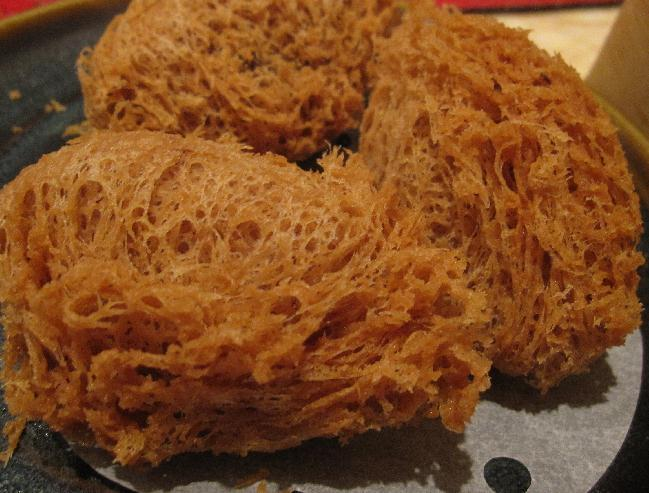

In [4]:
dataset[0]["image"]

In [5]:
dataset[0]["caption"]

'Three Taro dumplings made with peeled taro, wheat flour, eggs and oil'

## Create PyTorch Dataset

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        transforms = v2.Compose([
          v2.RandomResizedCrop(size=(364, 364),scale=(0.75, 1.0), antialias=True),
          v2.RandomHorizontalFlip(p=0.5),
        ])
        image = transforms(image)
        encoding = self.processor(images=image, padding=True, return_tensors="pt",
                                  do_resize=True, size=(364,364),do_normalize = True)
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["caption"] = item["caption"]
        return encoding

def collate_fn(batch):
  # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "caption":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["caption"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch

## Load Model

In [7]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b",torch_dtype = torch.float16)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Convert loaded model to PEFT for Lora fine-tuning

In [8]:
from peft import LoraConfig, get_peft_model

# Configureation for Lora
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj","v_proj","lm_head"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 8,709,632 || all params: 3,753,389,568 || trainable%: 0.23204710947819207


## Fine-tuning

In [9]:
import random
import numpy as np
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

In [10]:
import math
# Define cosine annealing learning rate scheduler with linear warmup
class LinearWarmupCosineLRSchedulerWithRestart:
    def __init__(self, optimizer, max_epoch, min_lr, init_lr, restart_step,warmup_steps=0, warmup_start_lr=-1):
        self.optimizer = optimizer

        self.max_epoch = max_epoch
        self.min_lr = min_lr

        self.init_lr = init_lr
        self.warmup_steps = warmup_steps
        self.warmup_start_lr = warmup_start_lr if warmup_start_lr >= 0 else init_lr
        self.restart_step = restart_step

    def step(self, cur_epoch, cur_step):
        # assuming the warmup iters less than one epoch
        if cur_epoch == 0:
            warmup_lr_schedule(
                step=cur_step,
                optimizer=self.optimizer,
                max_step=self.warmup_steps,
                init_lr=self.warmup_start_lr,
                max_lr=self.init_lr,
            )
        else:
            cosine_lr_schedule(
                epoch=cur_epoch % self.restart_step,
                optimizer=self.optimizer,
                max_epoch=self.max_epoch,
                init_lr=self.init_lr,
                min_lr=self.min_lr,
            )

def cosine_lr_schedule(optimizer, epoch, max_epoch, init_lr, min_lr):
    """Decay the learning rate"""
    lr = (init_lr - min_lr) * 0.5 * (
        1.0 + math.cos(math.pi * epoch / max_epoch)
    ) + min_lr
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def warmup_lr_schedule(optimizer, step, max_step, init_lr, max_lr):
    """Warmup the learning rate"""
    lr = min(max_lr, init_lr + (max_lr - init_lr) * step / max(max_step, 1))
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [11]:
train_dataset = ImageCaptioningDataset(train_set, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32, collate_fn=collate_fn)
val_dataset = ImageCaptioningDataset(validation_set, processor)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=32, collate_fn=collate_fn)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
scheduler = LinearWarmupCosineLRSchedulerWithRestart(optimizer,max_epoch = 30, min_lr = 0,
                                          init_lr = 3e-5,warmup_steps=50,warmup_start_lr=1e-8,
                                                     restart_step=30)
device = "cuda" if torch.cuda.is_available() else "cpu"
num_epochs = 300

# Gradient accumulation to accomodate small GPU VRam
gradient_accumulation_steps = 1

model.to(device)
for epoch in range(num_epochs):
  # Training phase
  model.train()
  train_loss = 0
  for idx, batch in enumerate(train_dataloader):
    scheduler.step(cur_epoch = epoch, cur_step = idx)
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)
    with torch.autocast(device_type='cuda', dtype=torch.float16):
      outputs = model(input_ids=input_ids,
                      pixel_values=pixel_values,
                      labels=input_ids)
    loss = outputs.loss
    loss = loss / gradient_accumulation_steps
    loss.backward()
    train_loss += loss.item()
    if ((idx + 1) % gradient_accumulation_steps == 0) or ((idx + 1)== len(train_dataloader)):
      optimizer.step()
      optimizer.zero_grad()
    if idx % 30 == 0:
      print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{idx + 1}/{len(train_dataloader)}],\
      Training Loss: {train_loss/(idx+1):.7f}, Learning rate:{optimizer.param_groups[0]['lr']:.7f}")
  # Evaluation phase
  model.eval()
  val_loss = 0
  with torch.no_grad():
    for idx, batch in enumerate(val_dataloader):
      input_ids = batch.pop("input_ids").to(device)
      pixel_values = batch.pop("pixel_values").to(device)
      with torch.autocast(device_type='cuda', dtype=torch.float16):
        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)
      v_loss = outputs.loss
      v_loss = loss / gradient_accumulation_steps
      val_loss += v_loss.item()
    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss/len(val_dataloader):.7f}")
  torch.cuda.empty_cache()

Epoch [1/300], Step [1/63],      Training Loss: 5.9637880, Learning rate:0.0000000
Epoch [1/300], Step [31/63],      Training Loss: 5.6606145, Learning rate:0.0000180
Epoch [1/300], Step [61/63],      Training Loss: 4.8579958, Learning rate:0.0000300
Epoch [1/300], Validation Loss: 3.3278170
Epoch [2/300], Step [1/63],      Training Loss: 2.8648832, Learning rate:0.0000299
Epoch [2/300], Step [31/63],      Training Loss: 2.2972680, Learning rate:0.0000299
Epoch [2/300], Step [61/63],      Training Loss: 2.0335090, Learning rate:0.0000299
Epoch [2/300], Validation Loss: 2.1450412
Epoch [3/300], Step [1/63],      Training Loss: 1.4859879, Learning rate:0.0000297
Epoch [3/300], Step [31/63],      Training Loss: 1.6658129, Learning rate:0.0000297
Epoch [3/300], Step [61/63],      Training Loss: 1.6398236, Learning rate:0.0000297
Epoch [3/300], Validation Loss: 1.6091403
Epoch [4/300], Step [1/63],      Training Loss: 1.5525572, Learning rate:0.0000293
Epoch [4/300], Step [31/63],      Trai

In [16]:
# Train for 100 additional epochs for better convergence
for i in range(100):
  epoch = i+300
  # Training phase
  model.train()
  train_loss = 0
  for idx, batch in enumerate(train_dataloader):
    scheduler.step(cur_epoch = epoch, cur_step = idx)
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)
    with torch.autocast(device_type='cuda', dtype=torch.float16):
      outputs = model(input_ids=input_ids,
                      pixel_values=pixel_values,
                      labels=input_ids)
    loss = outputs.loss
    loss = loss / gradient_accumulation_steps
    loss.backward()
    train_loss += loss.item()
    if ((idx + 1) % gradient_accumulation_steps == 0) or ((idx + 1)== len(train_dataloader)):
      optimizer.step()
      optimizer.zero_grad()
    if idx % 30 == 0:
      print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{idx + 1}/{len(train_dataloader)}],\
      Training Loss: {train_loss/(idx+1):.7f}, Learning rate:{optimizer.param_groups[0]['lr']:.7f}")
  # Evaluation phase
  model.eval()
  val_loss = 0
  with torch.no_grad():
    for idx, batch in enumerate(val_dataloader):
      input_ids = batch.pop("input_ids").to(device)
      pixel_values = batch.pop("pixel_values").to(device)
      with torch.autocast(device_type='cuda', dtype=torch.float16):
        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)
      v_loss = outputs.loss
      v_loss = loss / gradient_accumulation_steps
      val_loss += v_loss.item()
    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss/len(val_dataloader):.7f}")
  torch.cuda.empty_cache()

Epoch [301/300], Step [1/63],      Training Loss: 0.5443056, Learning rate:0.0000300
Epoch [301/300], Step [31/63],      Training Loss: 0.4487248, Learning rate:0.0000300
Epoch [301/300], Step [61/63],      Training Loss: 0.4582424, Learning rate:0.0000300
Epoch [301/300], Validation Loss: 0.5613945
Epoch [302/300], Step [1/63],      Training Loss: 0.4008680, Learning rate:0.0000299
Epoch [302/300], Step [31/63],      Training Loss: 0.4509730, Learning rate:0.0000299
Epoch [302/300], Step [61/63],      Training Loss: 0.4676417, Learning rate:0.0000299
Epoch [302/300], Validation Loss: 0.4683857
Epoch [303/300], Step [1/63],      Training Loss: 0.4309580, Learning rate:0.0000297
Epoch [303/300], Step [31/63],      Training Loss: 0.4492198, Learning rate:0.0000297
Epoch [303/300], Step [61/63],      Training Loss: 0.4646048, Learning rate:0.0000297
Epoch [303/300], Validation Loss: 0.4946403
Epoch [304/300], Step [1/63],      Training Loss: 0.4386415, Learning rate:0.0000293
Epoch [304/3

In [17]:
# Check training results
inputs = processor(images=dataset[0]['image'], return_tensors="pt").to(device, torch.float16)
pixel_values = inputs.pixel_values
generated_ids = model.generate(pixel_values=pixel_values, max_new_tokens=30)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

Three Taro dumplings with a golden and crisp crust and filled with yellow bean paste.


## Upload fine-tuned model to Huaagingface

In [18]:
from huggingface_hub import notebook_login
notebook_login()
model.push_to_hub("advancedcv/blip2-opt-2.7b_Food500Cap_finetuned_subset")

adapter_model.safetensors:   0%|          | 0.00/34.9M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/advancedcv/blip2-opt-2.7b_Food500Cap_finetuned_subset/commit/f46f732993aa81a3405de9c5780adf388e93b791', commit_message='Upload model', commit_description='', oid='f46f732993aa81a3405de9c5780adf388e93b791', pr_url=None, pr_revision=None, pr_num=None)